<a href="https://colab.research.google.com/github/nelsonalbertohj/Magno-Parvo-CNN/blob/main/Magno_parvo_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd

import keras
import time
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Average
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
N_CLASSES = 50
root = f"/content/drive/MyDrive/Vision Dataset/Imagenet-{N_CLASSES}-1500-splits/"
loc = root + "train"
data_dir = pathlib.Path(loc)

batch_size = 32
img_height = 224
img_width = 224

#Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Testing set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60058 files belonging to 50 classes.
Using 54053 files for training.
Found 60058 files belonging to 50 classes.
Using 6005 files for validation.


In [5]:
def img_transforms(data,label):
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    gray_norm_img = tfa.image.gaussian_filter2d(gray_norm_img,filter_shape=(10,10),sigma=5.0)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

AUTOTUNE = tf.data.AUTOTUNE

train_ds_preprocessed = train_ds.map(img_transforms)
val_ds_preprocessed = val_ds.map(img_transforms)

#NOTE: THE CASHE ON DISK IS ONLY NECESSARY IF HAVING ISSUES WITH IMAGE LOADING BOTTLENECK
CASHE_Train = f"{root}CASHE_Train_Blur_{N_CLASSES}_1500"
CASHE_Val = f"{root}CASHE_Val_Blur_{N_CLASSES}_1500"
train_ds_preprocessed = train_ds_preprocessed.cache(CASHE_Train).prefetch(buffer_size=AUTOTUNE)
val_ds_preprocessed = val_ds_preprocessed.cache(CASHE_Val).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Used to create CASHE in local disk by loading all images
idx = 0
start_time = time.time()
for t in train_ds_preprocessed:
  print("time to get object: ", time.time()-start_time)
  idx += 1
  start_time = time.time()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


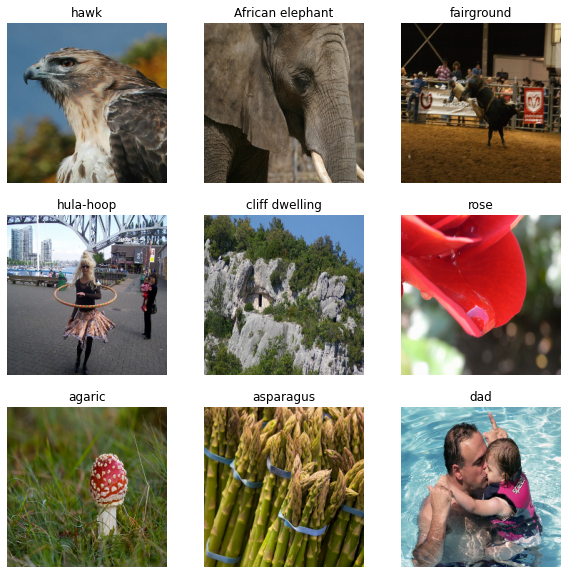

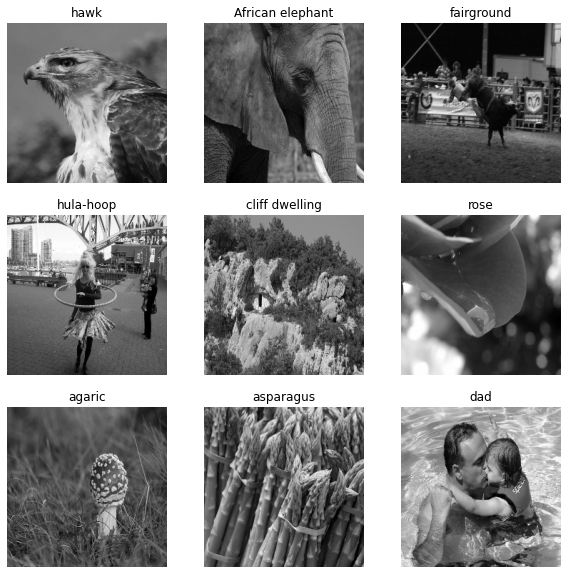

In [10]:
#Need to run to test that the correct image transformations were applied

class_names = train_ds.class_names
gray_imgs = []
plt.figure(figsize=(10, 10))
for images, labels in train_ds_preprocessed.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        plt.imshow(current_img.numpy()[:,:,:-1])
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.figure(figsize=(10, 10))
for images, labels in train_ds_preprocessed.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        plt.imshow(current_img.numpy()[:,:,-1],cmap="gray")
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [ ]:
#Visualizing gray images and other effects

np.random.seed(0)

def img_transforms_no_blur(data,label):
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

val_ds_preprocessed_no_blur = val_ds.map(img_transforms_no_blur)

class_names = train_ds.class_names
gray_imgs = []
plt.figure(figsize=(10, 10))
for images, labels in val_ds_preprocessed_no_blur.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        plt.imshow(current_img.numpy()[:,:,-1],cmap="gray")
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(gray_imgs):
      ax = plt.subplot(3, 3, i + 1)
      blurred_img = tfa.image.gaussian_filter2d(images[:,:,-1:],filter_shape=(10,10),sigma=5.0)
      plt.imshow(blurred_img.numpy().squeeze(),cmap="gray")
      plt.title(class_names[labels])
      plt.axis("off")

### Dual Stream ResNet Architecture

In [ ]:
from keras.backend import dropout
class DualStream_ResNet(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, freeze = True, load_type=None, 
                 merge_type="averaging"):
        super().__init__()
        self.n_outputs =  n_outputs
        self.merge_type = merge_type

        self.parv_stream = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=n_outputs,
                            )
        
        self.mag_stream = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=n_outputs,
                            )
        if freeze:
          self.parv_stream.trainable = False
          self.mag_stream.trainable = False

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([#tf.keras.layers.Dense(2048,activation='ReLU'),
                              # tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.concat = tf.keras.layers.Concatenate()

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]
        gray_input = inputs[:,:,:,-1:]
        concat_gray_input = tf.concat([gray_input,
                                      gray_input,
                                      gray_input],axis=-1)

        parvo_stream = self.parv_stream(color_input)
        parvo_stream = self.flat(parvo_stream)
        
        magno_stream = self.mag_stream(concat_gray_input)
        magno_stream = self.flat(magno_stream)
        
        if self.merge_type == "averaging":
          avg_outputs = self.avg([magno_stream,parvo_stream])
        elif self.merge_type == "concat":
          avg_outputs = self.concat([magno_stream,parvo_stream])
        else:
          raise "That layer option is not available"
        return self.fc(avg_outputs)

In [ ]:
FREEZE = False 
LOAD_WEIGHTS = None #One of None or imagenet
dual_stream_model = DualStream_ResNet(10,batch_size,FREEZE,load_type=LOAD_WEIGHTS,
                                      merge_type="averaging")
dual_stream_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model_save_loc = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/"
model_name = "Dualstream_with_ResNet_1000_Samples_Deeper_10Classes/"
checkpoint_path = f"{model_save_loc}{model_name}"
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only = True,
                                                 monitor='val_accuracy',
                                                 verbose=1)

train_history = dual_stream_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 60, callbacks=[callback,cp_callback], workers = 4)

# dual_stream_model.save()

#Save training history to CSV
hist_df = pd.DataFrame(train_history.history)

hist_csv_file = f"{model_save_loc}{model_name}_history.csv"
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

plt.figure()
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model_save_loc = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/"
model_name = "Dualstream_with_ResNet_1000_Samples_Deeper_10Classes/"
checkpoint_path = f"{model_save_loc}{model_name}"
#Load Model:
dual_stream_model = tf.keras.models.load_model(checkpoint_path)
# eval_loss, eval_accuracy = dual_stream_model.evaluate(val_ds_preprocessed)


### Simple ResNet architectur test

In [ ]:
#Testing Pure ResNet Model Training
from keras.backend import dropout
class Single_ResNet(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, freeze = True, load_type=None, 
                 merge_type="averaging"):
        super().__init__()
        self.n_outputs =  n_outputs
        self.merge_type = merge_type

        self.parv_stream = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=n_outputs,
                            )
        if freeze:
          self.parv_stream.trainable = False

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([#tf.keras.layers.Dense(2048,activation='ReLU'),
                              #tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.concat = tf.keras.layers.Concatenate()

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]

        parvo_stream = self.parv_stream(color_input)
        parvo_stream = self.flat(parvo_stream)

        return self.fc(parvo_stream)

In [ ]:
FREEZE = False 
LOAD_WEIGHTS = None #One of None or imagenet
signle_resnet_model = Single_ResNet(10,batch_size,FREEZE,load_type=LOAD_WEIGHTS,
                                      merge_type="averaging")
signle_resnet_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

train_history = signle_resnet_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 30, callbacks=callback, workers = 4)
signle_resnet_model.save("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/Single_ResNet_1000_Samples_Deeper")

Epoch 1/30
291/291 [==============================] - 72s 227ms/step - loss: 13.6862 - accuracy: 0.1110 - val_loss: 2.3041 - val_accuracy: 0.1156
Epoch 2/30
291/291 [==============================] - 64s 219ms/step - loss: 2.2606 - accuracy: 0.1448 - val_loss: 2.2146 - val_accuracy: 0.1586
Epoch 3/30
291/291 [==============================] - 64s 219ms/step - loss: 2.2257 - accuracy: 0.1625 - val_loss: 2.1758 - val_accuracy: 0.1844
Epoch 4/30
291/291 [==============================] - 63s 216ms/step - loss: 2.1793 - accuracy: 0.1795 - val_loss: 2.1855 - val_accuracy: 0.1624
Epoch 5/30
291/291 [==============================] - 64s 220ms/step - loss: 2.1579 - accuracy: 0.1872 - val_loss: 2.0857 - val_accuracy: 0.1990
Epoch 6/30
291/291 [==============================] - 64s 220ms/step - loss: 2.1143 - accuracy: 0.2057 - val_loss: 2.0430 - val_accuracy: 0.2119
Epoch 7/30
291/291 [==============================] - 64s 219ms/step - loss: 2.0276 - accuracy: 0.2475 - val_loss: 1.8438 - val_a

INFO:tensorflow:Assets written to: /content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/Single_ResNet_1000_Samples_Deeper/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/Single_ResNet_1000_Samples_Deeper/assets


### Dual Stream CNN Net
Implemented AlexNet-like neural net. It has easier training procedure and more meaningful Magno and Parvo implementations

In [ ]:
|class DualStream_CNN(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, load_type="imagenet", merge_type="averaging"):
        super().__init__()
        self.n_outputs =  n_outputs
        self.merge_type = merge_type

        self.parv_stream = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))])
        # keras.layers.Flatten()])
        
        self.mag_stream = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(13,13), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(7,7), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))])
        # keras.layers.Flatten()])

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([#tf.keras.layers.Dense(2048,activation='ReLU'),
                              #tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.concat = tf.keras.layers.Concatenate()

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]
        gray_input = inputs[:,:,:,-1:]
        concat_gray_input = tf.concat([gray_input,
                                      gray_input,
                                      gray_input],axis=-1)

        parvo_stream = self.parv_stream(color_input)
        parvo_stream = self.flat(parvo_stream)
        
        magno_stream = self.mag_stream(concat_gray_input)
        magno_stream = self.flat(magno_stream)
        
        if self.merge_type == "averaging":
          avg_outputs = self.avg([magno_stream,parvo_stream])
        elif self.merge_type == "concat":
          avg_outputs = self.concat([magno_stream,parvo_stream])
        else:
          raise "That layer option is not available"
        return self.fc(avg_outputs)

Epoch 1/60
327/328 [============================>.] - ETA: 0s - loss: 2.9287 - accuracy: 0.2790
Epoch 1: val_accuracy improved from -inf to 0.28805, saving model to /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 81s 238ms/step - loss: 2.9276 - accuracy: 0.2791 - val_loss: 2.0330 - val_accuracy: 0.2880
Epoch 2/60
327/328 [============================>.] - ETA: 0s - loss: 1.7358 - accuracy: 0.3944
Epoch 2: val_accuracy did not improve from 0.28805
328/328 [==============================] - 35s 106ms/step - loss: 1.7360 - accuracy: 0.3944 - val_loss: 3.3067 - val_accuracy: 0.1436
Epoch 3/60
327/328 [============================>.] - ETA: 0s - loss: 1.5964 - accuracy: 0.4625
Epoch 3: val_accuracy improved from 0.28805 to 0.49785, saving model to /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 41s 123ms/step - loss: 1.5963 - accuracy: 0.4626 - val_loss: 1.5257 - val_accuracy: 0.4979
Epoch 4/60
327/328 [============================>.] - ETA: 0s - loss: 1.4707 - accuracy: 0.5042
Epoch 4: val_accuracy did not improve from 0.49785
328/328 [==============================] - 72s 219ms/step - loss: 1.4705 - accuracy: 0.5043 - val_loss: 1.5544 - val_accuracy: 0.4686
Epoch 5/60
327/328 [============================>.] - ETA: 0s - loss: 1.3641 - accuracy: 0.5530
Epoch 5: val_accuracy improved from 0.49785 to 0.55890, saving model to /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 95s 288ms/step - loss: 1.3641 - accuracy: 0.5531 - val_loss: 1.2956 - val_accuracy: 0.5589
Epoch 6/60
327/328 [============================>.] - ETA: 0s - loss: 1.2538 - accuracy: 0.5876
Epoch 6: val_accuracy did not improve from 0.55890
328/328 [==============================] - 82s 250ms/step - loss: 1.2537 - accuracy: 0.5877 - val_loss: 1.9017 - val_accuracy: 0.4282
Epoch 7/60
328/328 [==============================] - ETA: 0s - loss: 1.1618 - accuracy: 0.6230
Epoch 7: val_accuracy improved from 0.55890 to 0.64488, saving model to /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 94s 287ms/step - loss: 1.1618 - accuracy: 0.6230 - val_loss: 1.0884 - val_accuracy: 0.6449
Epoch 8/60
327/328 [============================>.] - ETA: 0s - loss: 1.0809 - accuracy: 0.6507
Epoch 8: val_accuracy did not improve from 0.64488
328/328 [==============================] - 83s 251ms/step - loss: 1.0808 - accuracy: 0.6507 - val_loss: 3.6152 - val_accuracy: 0.2588
Epoch 9/60
327/328 [============================>.] - ETA: 0s - loss: 1.0401 - accuracy: 0.6713
Epoch 9: val_accuracy improved from 0.64488 to 0.64918, saving model to /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 95s 289ms/step - loss: 1.0403 - accuracy: 0.6712 - val_loss: 1.1350 - val_accuracy: 0.6492
Epoch 10/60
328/328 [==============================] - ETA: 0s - loss: 0.9681 - accuracy: 0.6971
Epoch 10: val_accuracy did not improve from 0.64918
328/328 [==============================] - 82s 250ms/step - loss: 0.9681 - accuracy: 0.6971 - val_loss: 1.1139 - val_accuracy: 0.6328
Epoch 11/60
327/328 [============================>.] - ETA: 0s - loss: 0.9062 - accuracy: 0.7201
Epoch 11: val_accuracy improved from 0.64918 to 0.68014, saving model to /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 95s 288ms/step - loss: 0.9060 - accuracy: 0.7201 - val_loss: 1.0649 - val_accuracy: 0.6801
Epoch 12/60
327/328 [============================>.] - ETA: 0s - loss: 0.8459 - accuracy: 0.7368
Epoch 12: val_accuracy did not improve from 0.68014
328/328 [==============================] - 83s 252ms/step - loss: 0.8457 - accuracy: 0.7369 - val_loss: 1.2555 - val_accuracy: 0.6036
Epoch 13/60
327/328 [============================>.] - ETA: 0s - loss: 0.7947 - accuracy: 0.7504
Epoch 13: val_accuracy did not improve from 0.68014
328/328 [==============================] - 89s 270ms/step - loss: 0.7945 - accuracy: 0.7504 - val_loss: 1.1042 - val_accuracy: 0.6690
Epoch 14/60
327/328 [============================>.] - ETA: 0s - loss: 0.7513 - accuracy: 0.7675
Epoch 14: val_accuracy did not improve from 0.68014
328/328 [==============================] - 89s 271ms/step - loss: 0.7511 - accuracy: 0.7675 - val_loss: 1.2320 - val_accuracy: 0.6303
Epoch 15/60
327/3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 96s 292ms/step - loss: 0.4631 - accuracy: 0.8639 - val_loss: 0.7982 - val_accuracy: 0.7868
Epoch 23/60
327/328 [============================>.] - ETA: 0s - loss: 0.4435 - accuracy: 0.8692
Epoch 23: val_accuracy did not improve from 0.78676
328/328 [==============================] - 82s 250ms/step - loss: 0.4435 - accuracy: 0.8692 - val_loss: 0.9078 - val_accuracy: 0.7481
Epoch 24/60
327/328 [============================>.] - ETA: 0s - loss: 0.3758 - accuracy: 0.8918
Epoch 24: val_accuracy did not improve from 0.78676
328/328 [==============================] - 89s 271ms/step - loss: 0.3770 - accuracy: 0.8917 - val_loss: 1.3596 - val_accuracy: 0.7120
Epoch 25/60
327/328 [============================>.] - ETA: 0s - loss: 0.3444 - accuracy: 0.8961
Epoch 25: val_accuracy did not improve from 0.78676
328/328 [==============================] - 89s 272ms/step - loss: 0.3457 - accuracy: 0.8960 - val_loss: 1.3465 - val_accuracy: 0.7008
Epoch 26/60
327/3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 95s 289ms/step - loss: 0.1955 - accuracy: 0.9447 - val_loss: 1.0435 - val_accuracy: 0.7919
Epoch 35/60
327/328 [============================>.] - ETA: 0s - loss: 0.1847 - accuracy: 0.9479
Epoch 35: val_accuracy did not improve from 0.79192
328/328 [==============================] - 83s 253ms/step - loss: 0.1846 - accuracy: 0.9480 - val_loss: 3.3244 - val_accuracy: 0.6242
Epoch 36/60
327/328 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9501
Epoch 36: val_accuracy improved from 0.79192 to 0.79622, saving model to /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 96s 291ms/step - loss: 0.1931 - accuracy: 0.9502 - val_loss: 1.1102 - val_accuracy: 0.7962
Epoch 37/60
327/328 [============================>.] - ETA: 0s - loss: 0.2007 - accuracy: 0.9451
Epoch 37: val_accuracy did not improve from 0.79622
328/328 [==============================] - 83s 252ms/step - loss: 0.2019 - accuracy: 0.9450 - val_loss: 1.1120 - val_accuracy: 0.7756
Epoch 38/60
327/328 [============================>.] - ETA: 0s - loss: 0.2494 - accuracy: 0.9365
Epoch 38: val_accuracy did not improve from 0.79622
328/328 [==============================] - 89s 272ms/step - loss: 0.2492 - accuracy: 0.9366 - val_loss: 2.1944 - val_accuracy: 0.6148
Epoch 39/60
327/328 [============================>.] - ETA: 0s - loss: 0.1729 - accuracy: 0.9536
Epoch 39: val_accuracy did not improve from 0.79622
328/328 [==============================] - 89s 272ms/step - loss: 0.1727 - accuracy: 0.9536 - val_loss: 1.2928 - val_accuracy: 0.7902
Epoch 40/60
327/3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 95s 290ms/step - loss: 0.1675 - accuracy: 0.9568 - val_loss: 1.2106 - val_accuracy: 0.8057
Epoch 42/60
327/328 [============================>.] - ETA: 0s - loss: 0.1426 - accuracy: 0.9623
Epoch 42: val_accuracy did not improve from 0.80567
328/328 [==============================] - 83s 254ms/step - loss: 0.1425 - accuracy: 0.9624 - val_loss: 1.0973 - val_accuracy: 0.7997
Epoch 43/60
327/328 [============================>.] - ETA: 0s - loss: 0.1780 - accuracy: 0.9564
Epoch 43: val_accuracy did not improve from 0.80567
328/328 [==============================] - 89s 272ms/step - loss: 0.1778 - accuracy: 0.9565 - val_loss: 5.1830 - val_accuracy: 0.5107
Epoch 44/60
327/328 [============================>.] - ETA: 0s - loss: 0.1228 - accuracy: 0.9669
Epoch 44: val_accuracy did not improve from 0.80567
328/328 [==============================] - 89s 272ms/step - loss: 0.1227 - accuracy: 0.9670 - val_loss: 1.3300 - val_accuracy: 0.7979
Epoch 45/60
327/3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 96s 292ms/step - loss: 0.1579 - accuracy: 0.9613 - val_loss: 1.3013 - val_accuracy: 0.8134
Epoch 47/60
327/328 [============================>.] - ETA: 0s - loss: 0.1795 - accuracy: 0.9589
Epoch 47: val_accuracy did not improve from 0.81341
328/328 [==============================] - 83s 252ms/step - loss: 0.1793 - accuracy: 0.9589 - val_loss: 1.8826 - val_accuracy: 0.7438
Epoch 48/60
328/328 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.9633
Epoch 48: val_accuracy did not improve from 0.81341
328/328 [==============================] - 89s 272ms/step - loss: 0.1515 - accuracy: 0.9633 - val_loss: 1.2323 - val_accuracy: 0.8014
Epoch 49/60
327/328 [============================>.] - ETA: 0s - loss: 0.1184 - accuracy: 0.9723
Epoch 49: val_accuracy did not improve from 0.81341
328/328 [==============================] - 90s 273ms/step - loss: 0.1183 - accuracy: 0.9723 - val_loss: 1.5020 - val_accuracy: 0.7747
Epoch 50/60
327/3

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/Dualstream_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 96s 291ms/step - loss: 0.1467 - accuracy: 0.9659 - val_loss: 1.1042 - val_accuracy: 0.8160
Epoch 52/60
327/328 [============================>.] - ETA: 0s - loss: 0.1027 - accuracy: 0.9746
Epoch 52: val_accuracy did not improve from 0.81599
328/328 [==============================] - 84s 255ms/step - loss: 0.1026 - accuracy: 0.9746 - val_loss: 1.8949 - val_accuracy: 0.7713
Epoch 53/60
327/328 [============================>.] - ETA: 0s - loss: 0.1063 - accuracy: 0.9731
Epoch 53: val_accuracy did not improve from 0.81599
328/328 [==============================] - 89s 272ms/step - loss: 0.1062 - accuracy: 0.9731 - val_loss: 1.5815 - val_accuracy: 0.7532
Epoch 54/60
327/328 [============================>.] - ETA: 0s - loss: 0.1215 - accuracy: 0.9706
Epoch 54: val_accuracy did not improve from 0.81599
328/328 [==============================] - 90s 273ms/step - loss: 0.1214 - accuracy: 0.9706 - val_loss: 2.1025 - val_accuracy: 0.6681
Epoch 55/60
327/3

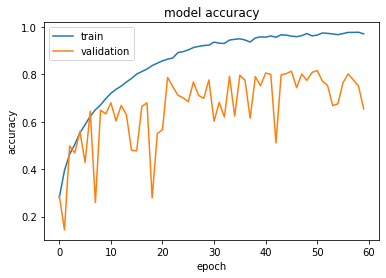

In [ ]:
dual_stream_model = DualStream_CNN(10,batch_size, load_type=None, merge_type="averaging")
dual_stream_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(
                          learning_rate=0.001), metrics = ['accuracy'])

model_save_loc = "/content/drive/MyDrive/Vision Dataset/Models/"
model_name = "Dualstream_with_VGG_1000_Samples_10Classes"
checkpoint_path = f"{model_save_loc}{model_name}"
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only = True,
                                                 monitor='val_accuracy',
                                                 verbose=1)

train_history = dual_stream_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 60, callbacks=[callback,cp_callback], workers = 4)

# dual_stream_model.save()

#Save training history to CSV
hist_df = pd.DataFrame(train_history.history)

hist_csv_file = f"{model_save_loc}{model_name}_history.csv"
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

plt.figure()
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
class DualFullRes_CNN(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, load_type="imagenet", merge_type="averaging"):
        super().__init__()
        self.n_outputs =  n_outputs
        self.merge_type = merge_type

        self.parv_stream1 = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))])
        
        self.parv_stream2 = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))])

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([#tf.keras.layers.Dense(2048,activation='ReLU'),
                              #tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.concat = tf.keras.layers.Concatenate()

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]

        parv1_stream = self.parv_stream1(color_input)
        parv1_stream = self.flat(parv1_stream)
        
        parv2_stream = self.parv_stream2(color_input)
        parv2_stream = self.flat(parv2_stream)
        
        if self.merge_type == "averaging":
          avg_outputs = self.avg([parv2_stream,parv1_stream])
        elif self.merge_type == "concat":
          avg_outputs = self.concat([parv2_stream,parv1_stream])
        else:
          raise "That layer option is not available"
        return self.fc(avg_outputs)

Epoch 1/60
328/328 [==============================] - ETA: 0s - loss: 2.7365 - accuracy: 0.3108
Epoch 1: val_accuracy improved from -inf to 0.27515, saving model to /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 282s 819ms/step - loss: 2.7365 - accuracy: 0.3108 - val_loss: 1.9695 - val_accuracy: 0.2752
Epoch 2/60
327/328 [============================>.] - ETA: 0s - loss: 1.6780 - accuracy: 0.4315
Epoch 2: val_accuracy did not improve from 0.27515
328/328 [==============================] - 53s 162ms/step - loss: 1.6784 - accuracy: 0.4315 - val_loss: 3.0913 - val_accuracy: 0.1462
Epoch 3/60
327/328 [============================>.] - ETA: 0s - loss: 1.4989 - accuracy: 0.4937
Epoch 3: val_accuracy did not improve from 0.27515
328/328 [==============================] - 54s 163ms/step - loss: 1.4989 - accuracy: 0.4937 - val_loss: 4.0206 - val_accuracy: 0.1040
Epoch 4/60
327/328 [============================>.] - ETA: 0s - loss: 1.3889 - accuracy: 0.5419
Epoch 4: val_accuracy did not improve from 0.27515
328/328 [==============================] - 53s 162ms/step - loss: 1.3890 - accuracy: 0.5418 - val_loss: 2.0954 - val_accuracy: 0.2631
Epoch 5/60
327/328 [==

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 60s 183ms/step - loss: 1.2872 - accuracy: 0.5679 - val_loss: 1.4108 - val_accuracy: 0.5245
Epoch 6/60
327/328 [============================>.] - ETA: 0s - loss: 1.1902 - accuracy: 0.6105
Epoch 6: val_accuracy did not improve from 0.52451
328/328 [==============================] - 53s 161ms/step - loss: 1.1903 - accuracy: 0.6104 - val_loss: 1.6666 - val_accuracy: 0.4265
Epoch 7/60
327/328 [============================>.] - ETA: 0s - loss: 1.1322 - accuracy: 0.6347
Epoch 7: val_accuracy did not improve from 0.52451
328/328 [==============================] - 53s 162ms/step - loss: 1.1320 - accuracy: 0.6346 - val_loss: 3.5072 - val_accuracy: 0.2657
Epoch 8/60
327/328 [============================>.] - ETA: 0s - loss: 1.0306 - accuracy: 0.6631
Epoch 8: val_accuracy did not improve from 0.52451
328/328 [==============================] - 53s 162ms/step - loss: 1.0304 - accuracy: 0.6631 - val_loss: 1.4003 - val_accuracy: 0.5176
Epoch 9/60
327/328 [===

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 109s 331ms/step - loss: 0.9280 - accuracy: 0.7081 - val_loss: 1.4065 - val_accuracy: 0.5580
Epoch 12/60
327/328 [============================>.] - ETA: 0s - loss: 0.8942 - accuracy: 0.7213
Epoch 12: val_accuracy improved from 0.55804 to 0.56922, saving model to /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 104s 317ms/step - loss: 0.8941 - accuracy: 0.7215 - val_loss: 1.4235 - val_accuracy: 0.5692
Epoch 13/60
327/328 [============================>.] - ETA: 0s - loss: 0.7982 - accuracy: 0.7462
Epoch 13: val_accuracy improved from 0.56922 to 0.66810, saving model to /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 103s 313ms/step - loss: 0.7978 - accuracy: 0.7464 - val_loss: 0.9959 - val_accuracy: 0.6681
Epoch 14/60
327/328 [============================>.] - ETA: 0s - loss: 0.7701 - accuracy: 0.7568
Epoch 14: val_accuracy did not improve from 0.66810
328/328 [==============================] - 98s 297ms/step - loss: 0.7699 - accuracy: 0.7569 - val_loss: 1.3302 - val_accuracy: 0.6268
Epoch 15/60
327/328 [============================>.] - ETA: 0s - loss: 0.7610 - accuracy: 0.7603
Epoch 15: val_accuracy did not improve from 0.66810
328/328 [==============================] - 104s 315ms/step - loss: 0.7607 - accuracy: 0.7604 - val_loss: 1.1822 - val_accuracy: 0.6397
Epoch 16/60
327/328 [============================>.] - ETA: 0s - loss: 0.7107 - accuracy: 0.7784
Epoch 16: val_accuracy did not improve from 0.66810
328/328 [==============================] - 65s 197ms/step - loss: 0.7105 - accuracy: 0.7785 - val_loss: 1.5871 - val_accuracy: 0.5090
Epoch 17/60
327

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 109s 332ms/step - loss: 0.6794 - accuracy: 0.7886 - val_loss: 1.0252 - val_accuracy: 0.6776
Epoch 19/60
327/328 [============================>.] - ETA: 0s - loss: 0.6233 - accuracy: 0.8101
Epoch 19: val_accuracy did not improve from 0.67756
328/328 [==============================] - 98s 297ms/step - loss: 0.6229 - accuracy: 0.8102 - val_loss: 1.5568 - val_accuracy: 0.5899
Epoch 20/60
327/328 [============================>.] - ETA: 0s - loss: 0.5765 - accuracy: 0.8245
Epoch 20: val_accuracy did not improve from 0.67756
328/328 [==============================] - 103s 315ms/step - loss: 0.5761 - accuracy: 0.8247 - val_loss: 1.2216 - val_accuracy: 0.6750
Epoch 21/60
327/328 [============================>.] - ETA: 0s - loss: 0.5416 - accuracy: 0.8336
Epoch 21: val_accuracy improved from 0.67756 to 0.70765, saving model to /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 109s 332ms/step - loss: 0.5414 - accuracy: 0.8337 - val_loss: 0.9660 - val_accuracy: 0.7077
Epoch 22/60
327/328 [============================>.] - ETA: 0s - loss: 0.5244 - accuracy: 0.8431
Epoch 22: val_accuracy did not improve from 0.70765
328/328 [==============================] - 98s 297ms/step - loss: 0.5239 - accuracy: 0.8432 - val_loss: 1.4102 - val_accuracy: 0.6905
Epoch 23/60
327/328 [============================>.] - ETA: 0s - loss: 0.5069 - accuracy: 0.8447
Epoch 23: val_accuracy did not improve from 0.70765
328/328 [==============================] - 103s 314ms/step - loss: 0.5065 - accuracy: 0.8448 - val_loss: 1.3812 - val_accuracy: 0.6165
Epoch 24/60
327/328 [============================>.] - ETA: 0s - loss: 0.4380 - accuracy: 0.8664
Epoch 24: val_accuracy improved from 0.70765 to 0.77128, saving model to /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 110s 334ms/step - loss: 0.4377 - accuracy: 0.8665 - val_loss: 0.8606 - val_accuracy: 0.7713
Epoch 25/60
327/328 [============================>.] - ETA: 0s - loss: 0.4217 - accuracy: 0.8753
Epoch 25: val_accuracy did not improve from 0.77128
328/328 [==============================] - 97s 296ms/step - loss: 0.4215 - accuracy: 0.8753 - val_loss: 2.1900 - val_accuracy: 0.5133
Epoch 26/60
327/328 [============================>.] - ETA: 0s - loss: 0.4069 - accuracy: 0.8781
Epoch 26: val_accuracy improved from 0.77128 to 0.78418, saving model to /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 109s 333ms/step - loss: 0.4066 - accuracy: 0.8782 - val_loss: 0.7747 - val_accuracy: 0.7842
Epoch 27/60
328/328 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.8842
Epoch 27: val_accuracy did not improve from 0.78418
328/328 [==============================] - 98s 297ms/step - loss: 0.3913 - accuracy: 0.8842 - val_loss: 1.0510 - val_accuracy: 0.7197
Epoch 28/60
327/328 [============================>.] - ETA: 0s - loss: 0.3498 - accuracy: 0.8940
Epoch 28: val_accuracy did not improve from 0.78418
328/328 [==============================] - 103s 314ms/step - loss: 0.3495 - accuracy: 0.8941 - val_loss: 1.0586 - val_accuracy: 0.7532
Epoch 29/60
327/328 [============================>.] - ETA: 0s - loss: 0.3549 - accuracy: 0.8953
Epoch 29: val_accuracy did not improve from 0.78418
328/328 [==============================] - 104s 315ms/step - loss: 0.3547 - accuracy: 0.8953 - val_loss: 0.9621 - val_accuracy: 0.7635
Epoch 30/60
32

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 109s 333ms/step - loss: 0.2547 - accuracy: 0.9240 - val_loss: 0.7533 - val_accuracy: 0.8143
Epoch 34/60
327/328 [============================>.] - ETA: 0s - loss: 0.2725 - accuracy: 0.9236
Epoch 34: val_accuracy did not improve from 0.81427
328/328 [==============================] - 98s 297ms/step - loss: 0.2723 - accuracy: 0.9237 - val_loss: 1.2100 - val_accuracy: 0.6879
Epoch 35/60
327/328 [============================>.] - ETA: 0s - loss: 0.2722 - accuracy: 0.9281
Epoch 35: val_accuracy did not improve from 0.81427
328/328 [==============================] - 103s 315ms/step - loss: 0.2720 - accuracy: 0.9282 - val_loss: 1.1588 - val_accuracy: 0.7747
Epoch 36/60
327/328 [============================>.] - ETA: 0s - loss: 0.2228 - accuracy: 0.9356
Epoch 36: val_accuracy did not improve from 0.81427
328/328 [==============================] - 104s 315ms/step - loss: 0.2226 - accuracy: 0.9356 - val_loss: 0.9458 - val_accuracy: 0.7962
Epoch 37/60
32

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Vision Dataset/Models/FullRes_with_VGG_1000_Samples_10Classes/assets


328/328 [==============================] - 109s 331ms/step - loss: 0.2080 - accuracy: 0.9442 - val_loss: 0.8964 - val_accuracy: 0.8229
Epoch 42/60
327/328 [============================>.] - ETA: 0s - loss: 0.1923 - accuracy: 0.9490
Epoch 42: val_accuracy did not improve from 0.82287
328/328 [==============================] - 98s 298ms/step - loss: 0.1921 - accuracy: 0.9490 - val_loss: 1.3218 - val_accuracy: 0.7696
Epoch 43/60
327/328 [============================>.] - ETA: 0s - loss: 0.2156 - accuracy: 0.9426
Epoch 43: val_accuracy did not improve from 0.82287
328/328 [==============================] - 103s 315ms/step - loss: 0.2154 - accuracy: 0.9426 - val_loss: 1.3836 - val_accuracy: 0.7274
Epoch 44/60
327/328 [============================>.] - ETA: 0s - loss: 0.1726 - accuracy: 0.9536
Epoch 44: val_accuracy did not improve from 0.82287
328/328 [==============================] - 103s 314ms/step - loss: 0.1724 - accuracy: 0.9536 - val_loss: 3.9781 - val_accuracy: 0.6242
Epoch 45/60
32

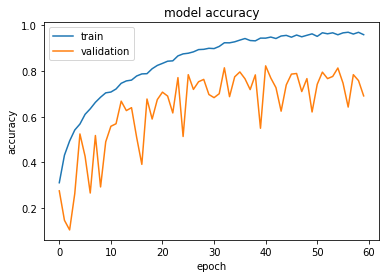

In [ ]:
dual_stream_model = DualFullRes_CNN(10,batch_size, load_type=None, merge_type="averaging")
dual_stream_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(
                          learning_rate=0.001), metrics = ['accuracy'])

model_save_loc = "/content/drive/MyDrive/Vision Dataset/Models/"
model_name = "FullRes_with_VGG_1000_Samples_10Classes"
checkpoint_path = f"{model_save_loc}{model_name}"
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only = True,
                                                 monitor='val_accuracy',
                                                 verbose=1)

train_history = dual_stream_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 60, callbacks=[callback,cp_callback], workers = 4)

# dual_stream_model.save()

#Save training history to CSV
hist_df = pd.DataFrame(train_history.history)

hist_csv_file = f"{model_save_loc}{model_name}_history.csv"
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

plt.figure()
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()